In [51]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal as sig

In [52]:
rate = 2000 #Sampling rate
interval = 1.0/rate #Sampling frequency
t = np.arange(0, 1, interval) #Time array

data_array_1 = 2*np.sin(2*np.pi*2*t) #Sinusoid of frequency 2 Hz 
data_array_2 = np.sin(2*np.pi*3*t) #Sinusoid of frequency 3 Hz

signal = data_array_1 + data_array_2 #Sum of sinusoids

SIGNAL_transform = np.fft.fft(signal) #Fourier transform of signal
N = len(SIGNAL_transform) #Number of data points in frequency domain
n = np.arange(N) #Array of N
T = N/rate #Sampling period
frequency = n/T #Sampling frequency

inverse = np.fft.ifft(SIGNAL_transform) #Inverse of the Fourier transform

C:\Users\linav\AppData\Roaming\Python\Python313\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\linav\AppData\Roaming\Python\Python313\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


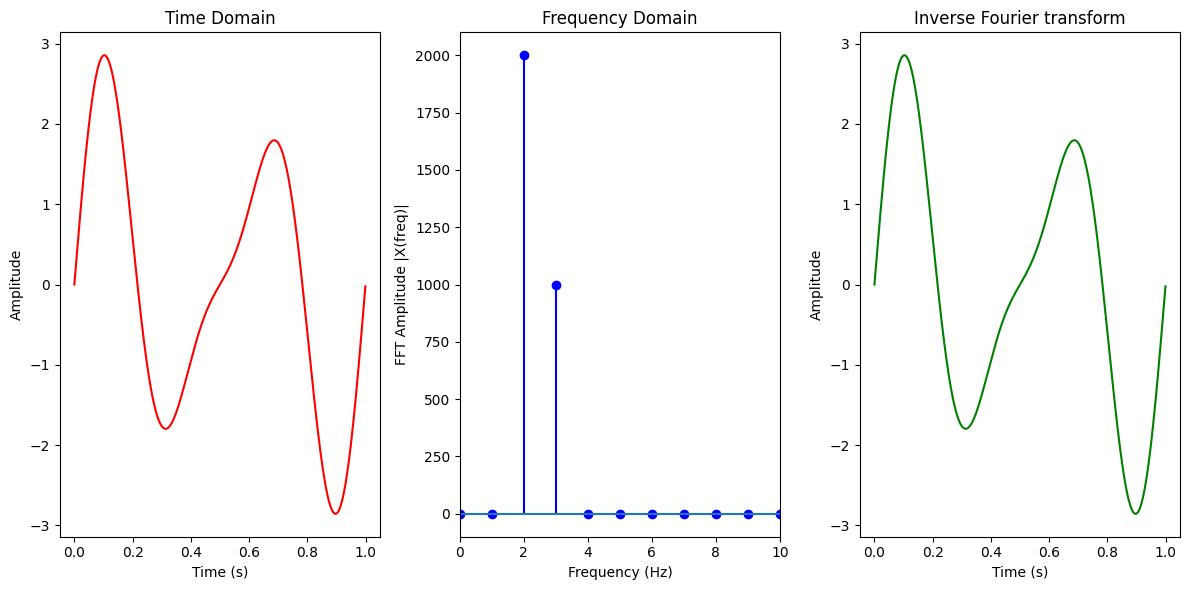

In [53]:
# Time domain plot
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.plot(t, signal, 'r')
plt.title('Time Domain')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Frequency domain plot
plt.subplot(132)
plt.stem(frequency, np.abs(SIGNAL_transform), 'b', markerfmt="o", basefmt="-")
plt.title('Frequency Domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

# Inverse transfrom domain plot
plt.subplot(133)
plt.plot(t, inverse, 'g')
plt.title('Inverse Fourier transform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

## Note theory

The frequencies of each keys of a piano are given by :

$$f(n)=\left(\sqrt[12]{2}\right)^{n-49}\times 440$$

with $n\in\N_0$.

In [54]:
N = 100 #Number of keys
keys = np.arange(1, N, 1)

notes = (np.power(2, (1/12)))**(keys-49)*440 # Frequencies of each notes

Text(0, 0.5, 'Frequency (Hz)')

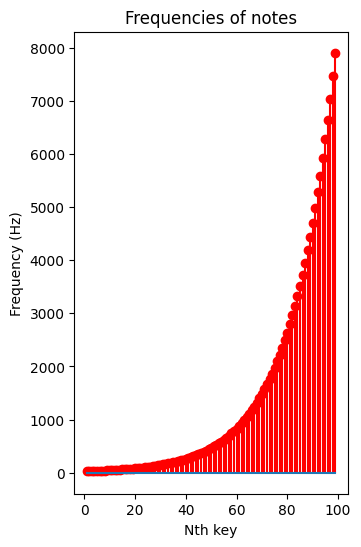

In [55]:
# Notes
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.stem(keys, notes, 'r', markerfmt="o", basefmt="-")
plt.title('Frequencies of notes')
plt.xlabel('Nth key')
plt.ylabel('Frequency (Hz)')


In [56]:
sample_path = "sample_1.mp3"
audio_signal, sample_rate = librosa.load(sample_path, sr=None, mono=False)

if audio_signal.ndim > 1:
    audio_signal = audio_signal[0, :]

cutoff_frequency = 5000 
nyquist = 2.0 * sample_rate 
normal_cutoff = cutoff_frequency / nyquist 

b, a = sig.butter(N=4, Wn=normal_cutoff, btype='low', analog=False)
filtered_signal = sig.filtfilt(b, a, audio_signal)

time = librosa.times_like(audio_signal, sr=sample_rate)

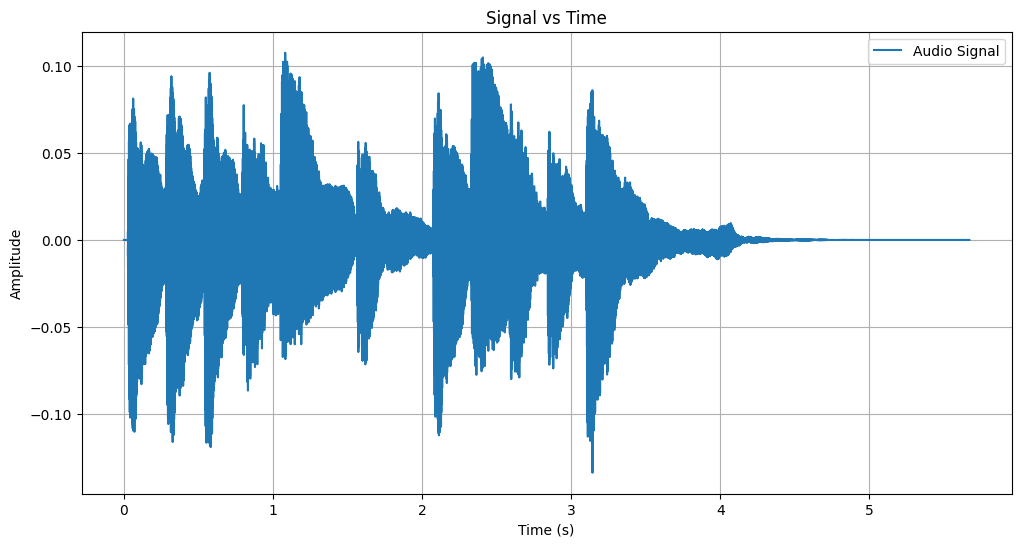

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(time/1000, filtered_signal, label="Audio Signal")
plt.title("Signal vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()

In [58]:
fft_result = np.fft.fft(filtered_signal)
frequencies = np.fft.fftfreq(len(fft_result), d=1/sample_rate)
magnitude = np.abs(fft_result)

filtered_fft_result = np.zeros_like(fft_result)
for target_frequency in notes:
    idx = np.argmin(np.abs(frequencies - target_frequency))
    filtered_fft_result[idx] = fft_result[idx] 

cleanup_threshold = 95
filtered_fft_result[np.abs(filtered_fft_result) < cleanup_threshold] = 0
    
filtered_magnitude = np.abs(filtered_fft_result)


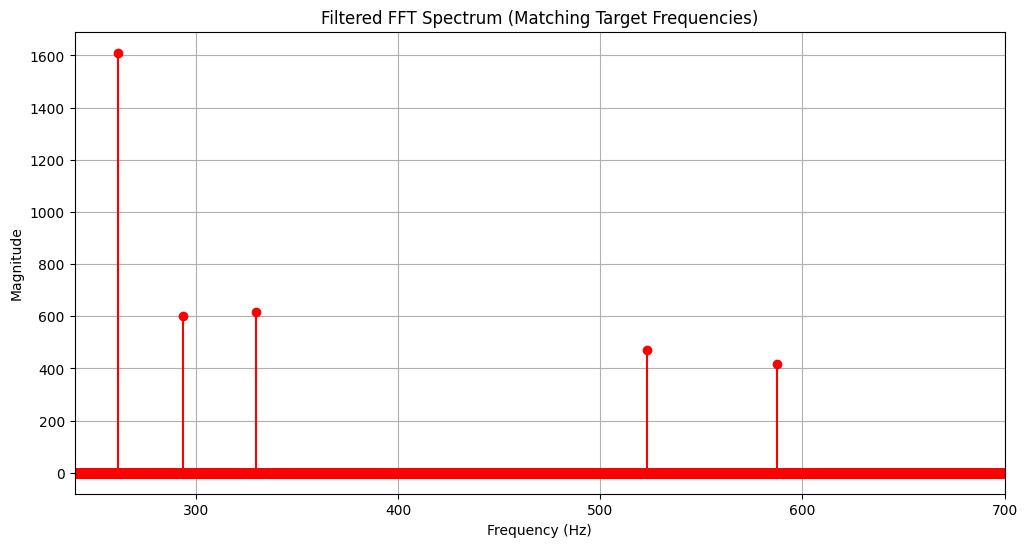

Displayed Frequencies and Magnitudes:
Frequency: 261.65 Hz, Magnitude: 1610.24
Frequency: 293.70 Hz, Magnitude: 599.41
Frequency: 329.63 Hz, Magnitude: 616.21
Frequency: 523.21 Hz, Magnitude: 470.55
Frequency: 587.31 Hz, Magnitude: 417.75


In [59]:
plt.figure(figsize=(12, 6))
plt.stem(frequencies[:len(frequencies)//2], filtered_magnitude[:len(filtered_magnitude)//2], 'r', markerfmt="o", basefmt=" ")
plt.title("Filtered FFT Spectrum (Matching Target Frequencies)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()
plt.xlim(240,700)
plt.show()

print("Displayed Frequencies and Magnitudes:")
for freq, mag in zip(frequencies, filtered_magnitude):
    if mag > 0: 
        print(f"Frequency: {freq:.2f} Hz, Magnitude: {mag:.2f}")

In [60]:
onset_env = librosa.onset.onset_strength(y=audio_signal, sr=sample_rate) #Compute onset envelope

#Detect onset times
onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sample_rate)
onset_times = librosa.frames_to_time(onset_frames, sr=sample_rate)

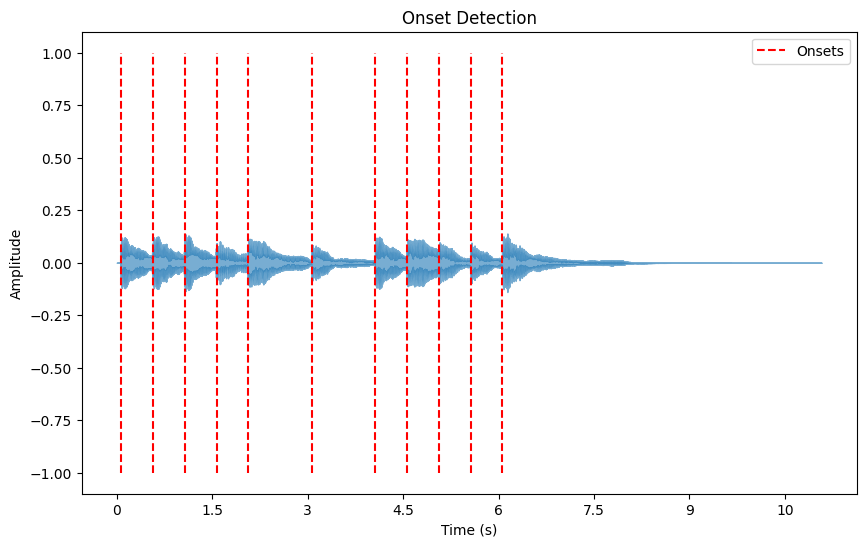

Onset times (in seconds): [0.05804989 0.56888889 1.06811791 1.56734694 2.06657596 3.06503401
 4.06349206 4.56272109 5.06195011 5.56117914 6.06040816]


In [61]:
#Plot the signal and onsets
plt.figure(figsize=(10, 6))
librosa.display.waveshow(audio_signal, sr=sample_rate, alpha=0.6)
plt.vlines(onset_times, -1, 1, color='r', linestyle='--', label='Onsets')
plt.title('Onset Detection')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

print("Onset times (in seconds):", onset_times) #Print onset times

In [62]:
#Segment the signal based on onset times
onset_samples = librosa.time_to_samples(onset_times, sr=sample_rate)
segments = [audio_signal[onset_samples[i]:onset_samples[i+1]] for i in range(len(onset_samples)-1)]
segments.append(audio_signal[onset_samples[-1]:])

print(f"Number of segments: {len(segments)}") #Verify the number of segments

Number of segments: 11


In [63]:
amplitude_threshold = 150 

selected_notes = np.zeros(len(segments)) 
lowest_frequency_notes = np.zeros(len(segments)) 

for i, segment in enumerate(segments):
    #Compute FFT
    fft_result = np.fft.fft(segment)
    frequencies = np.fft.fftfreq(len(fft_result), d=1/sample_rate)
    magnitude = np.abs(fft_result)
    
    #Apply amplitude threshold
    fft_result[magnitude < amplitude_threshold] = 0
    magnitude = np.abs(fft_result)  #Recompute magnitude after cleanup
    
    #Find dominant frequency
    dominant_frequency = frequencies[np.argmax(magnitude)]
    
    #Compare dominant frequency to the notes array
    closest_note = notes[np.argmin(np.abs(notes - dominant_frequency))]
    selected_notes[i] = closest_note
    
    valid_frequencies = frequencies[(frequencies > 0) & (magnitude > 0)] #We filter out frequencies associated with zero magnitudes.
    if len(valid_frequencies) > 0: #If there are vaild frequencies
        lowest_frequency = valid_frequencies.min() #We find the lowest frequency
        lowest_closest_note = notes[np.argmin(np.abs(notes - lowest_frequency))] #We find the closest note in the array
        lowest_frequency_notes[i] = lowest_closest_note #We
        print(f"Note {i+1}: Lowest Frequency Closest Note = {lowest_closest_note:.2f} Hz")
    else:
        lowest_frequency_notes[i] = np.nan  # Use NaN for no valid lowest frequency
        print(f"Note {i+1}: No valid lowest frequency found.")

print('\n')
print("Lowest Frequency Closest Notes (as NumPy array):", lowest_frequency_notes) #Print the frequencies identified


Note 1: Lowest Frequency Closest Note = 261.63 Hz
Note 2: Lowest Frequency Closest Note = 261.63 Hz
Note 3: Lowest Frequency Closest Note = 261.63 Hz
Note 4: Lowest Frequency Closest Note = 293.66 Hz
Note 5: Lowest Frequency Closest Note = 329.63 Hz
Note 6: Lowest Frequency Closest Note = 293.66 Hz
Note 7: Lowest Frequency Closest Note = 261.63 Hz
Note 8: Lowest Frequency Closest Note = 329.63 Hz
Note 9: Lowest Frequency Closest Note = 293.66 Hz
Note 10: Lowest Frequency Closest Note = 293.66 Hz
Note 11: Lowest Frequency Closest Note = 261.63 Hz


Lowest Frequency Closest Notes (as NumPy array): [261.6255653  261.6255653  261.6255653  293.66476792 329.62755691
 293.66476792 261.6255653  329.62755691 293.66476792 293.66476792
 261.6255653 ]
